<a href="https://colab.research.google.com/github/Swati-161/Week-1-ML-task-/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset Preview:

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.00527

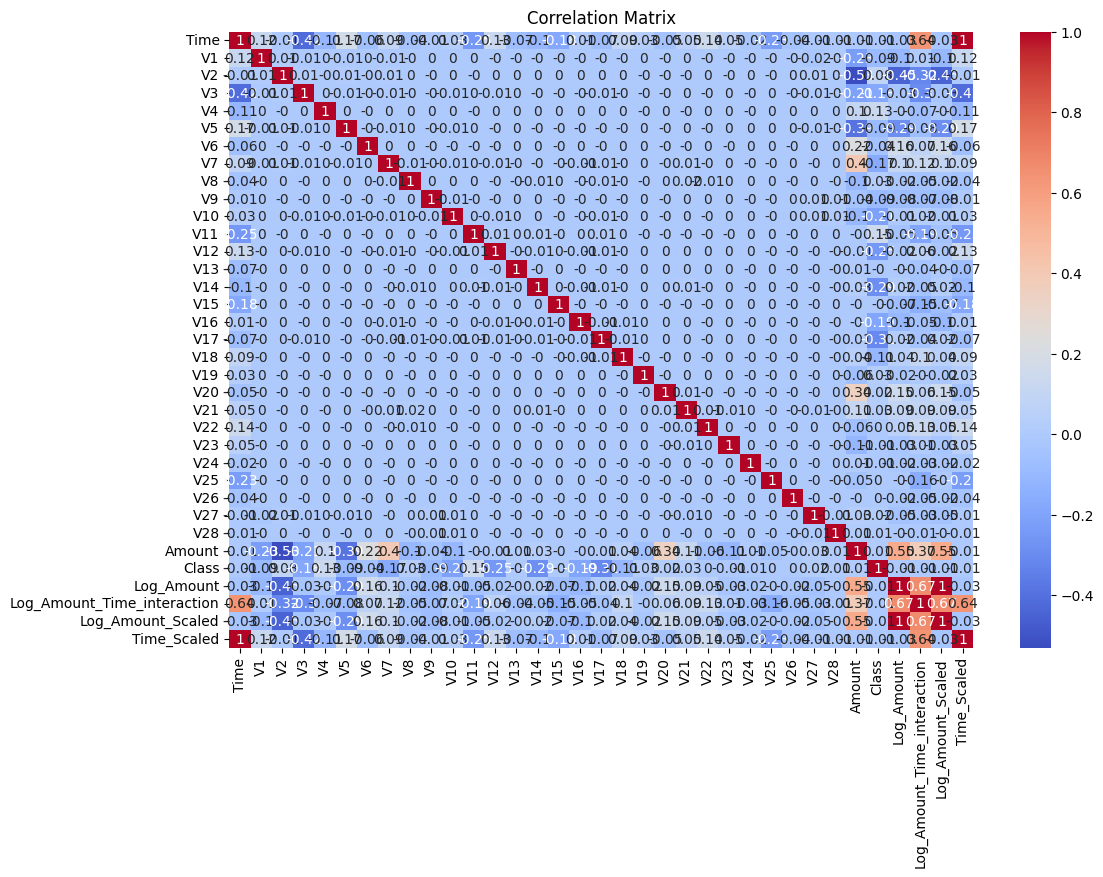


VIF resuts

      Variable        VIF
0        const  15.557223
1         Time   1.884362
2           V1   1.656772
3           V2   4.568782
4           V3   1.881996
5           V4   1.144401
6           V5   2.897298
7           V6   1.589527
8           V7   2.929076
9           V8   1.134619
10          V9   1.031171
11         V10   1.126805
12         V11   1.120510
13         V12   1.030960
14         V13   1.008540
15         V14   1.032187
16         V15   1.072134
17         V16   1.017081
18         V17   1.011700
19         V18   1.032971
20         V19   1.039939
21         V20   2.407257
22         V21   1.143523
23         V22   1.098680
24         V23   1.164407
25         V24   1.001369
26         V25   1.131994
27         V26   1.003889
28         V27   1.016448
29         V28   1.001794
30      Amount  12.543370
31  Log_Amount   1.679080

Processed Data Preview:

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.0

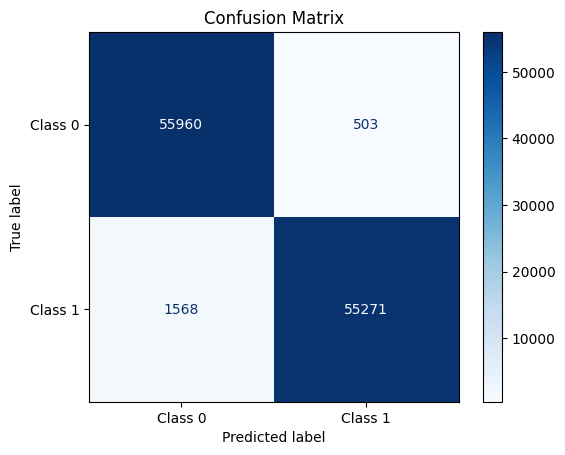

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# link for the dataset used
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Load the dataset
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')

# Preview the first 5 rows
print("\nDataset Preview:\n")
print(df.head())

# Row & Column count
print("\nDataset Shape:", df.shape)
# Statistics of data
print("\nDataset Statistics:\n")
print(df.describe())
# Information about the dataset
print("\nDataset Info:\n")
print(df.info())

#Check for missing values
print("\nMissing Values Count:\n")
print(df.isnull().sum())

# Fill missing values with the median
df.fillna(df.median(), inplace=True)

# Identify and remove duplicates
print(f"\nRows before removing duplicates: {df.shape[0]}")
df_no_duplicates = df.drop_duplicates()
print(f"\nRows after removing duplicates: {df_no_duplicates.shape[0]}")

pd.options.mode.copy_on_write = True

#all columns are numeric, no encoding is necessary

# Apply log transformation to 'Amount'
df_no_duplicates['Log_Amount'] = np.log1p(df_no_duplicates['Amount'])

# Interaction feature between log_Amount and Time
df_no_duplicates['Log_Amount_Time_interaction'] = df_no_duplicates['Log_Amount'] * df_no_duplicates['Time']


# Initialize the scaler
scaler = StandardScaler()
# Apply scaling to 'Log_Amount' and 'Time' columns
df_no_duplicates[['Log_Amount_Scaled', 'Time_Scaled']] = scaler.fit_transform(df_no_duplicates[['Log_Amount', 'Time']])

# Binning the Amount Column based on Quantiles (Dynamic Binning)
df_no_duplicates['Amount_Binned'] = pd.qcut(df_no_duplicates['Amount'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Correlation Matrix
numeric_columns = df_no_duplicates.select_dtypes(include=[np.number]).columns
corr_matrix = df_no_duplicates[numeric_columns].corr()
corr_matrix_rounded = corr_matrix.round(2)

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_rounded, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Calculate Variance Inflation Factor (VIF)
columns_to_drop = ['Class', 'Log_Amount_Time_interaction', 'Amount_Binned','Log_Amount_Scaled', 'Time_Scaled']
X = df_no_duplicates.drop(
    columns=[col for col in columns_to_drop if col in df_no_duplicates.columns]
)
X = add_constant(X)
X = X.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF resuts\n")
print(vif_data)

# View processed data
print("\nProcessed Data Preview:\n")
print(df_no_duplicates.head())

# Separate features and target variable
X = df_no_duplicates.drop(columns=['Class', 'Amount_Binned'], errors='ignore')
y = df_no_duplicates['Class']

# Apply SMOTE for class imbalance handling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=10000, solver='lbfgs', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Class 0', 'Class 1'], cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


